![imagen](data/foto1.png)

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.io import imread
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from time import time



Convolucional: Operación matemática convolución
1. Campo recpetivo- Kernel
2. Extractor de Features -> Aplanado + Modelo



### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras.



### Resolución

### #1

#### Carga de Datos (y train test split de regalo)

*Vamos a crear los datasets, adaptamos la función para que en vez de admitir un único directorio admita una lista de ellos*

In [2]:
# importamos data.zip
#!rm -r ./data
!mkdir data

In [3]:
import zipfile
path_to_zip_file = "./data.zip"
directory_to_extract_to = "./data/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [4]:
def read_data(directorios, reshape_dim = (32,32)):
    X = []
    y = []
    mapa_imagen_fichero = []
    directorios = directorios if isinstance(directorios, list) else [directorios] if isinstance(directorios,str) else []
    for directorio in directorios:
        for file in os.listdir(directorio):
            image = imread('/'.join([directorio, file]))
            image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
            X.append(image)
            y.append(file.split(".")[0]) # El nombre es la clase
            mapa_imagen_fichero.append(file) # Esto para ver la imagen al completo con su resolución

    return np.array(X),np.array(y),mapa_imagen_fichero

*Empezamos con el X_train, y_train a partir de los subdirectorios correspondientes*

In [5]:
PATH_DATA = "./data/data/"
directorios  = [f"{PATH_DATA}github_train_{i}" for i in range(0,4)]
X_train,y_train, train_map = read_data(directorios)

*Ahora el test*

In [6]:
directorios  = [PATH_DATA + "github_test"]
X_test,y_test, test_map = read_data(directorios)

#### Visualización de datos

*Un pequeño vistazo al tipo y tamaño de nuestros datos*

In [7]:
X_train.shape

(4000, 32, 32, 3)

*Train: 4000 imágenes, de 32x32 y en color, 3 canales*

In [8]:
type(X_train[123]) # la foto 123

numpy.ndarray

*Y son arrays como ya sabíamos porque es lo que retorna nuestra función :-)*

In [9]:
X_test.shape

(1000, 32, 32, 3)

*Test: 1000 imágenes de 32x32, en color, 3 canales*

*Para ver nuestros datos, reutilizamos directamente la función creada para el ejercicio de los paisajes*

In [10]:
def show_images_batch(pets, names = [], n_cols = 5, size_scale = 2): # 5 fotos sacadas de las imágenes reescaladas
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale)) # size_scale para el tamaño de la figura
    for index, pet in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(pet, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [11]:
def show_images_files(pets, names = [], n_cols = 5, size_scale = 2, train = True, indice = 0):# igual que arriba pero con imágenes sin reescalar, con train y la parte del directorio de train
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, filepet in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        if train:
            pet = imread(PATH_DATA + f"github_train_{indice}/" + filepet)
        else:
            pet = imread(PATH_DATA + "github_test/" + filepet)
        plt.imshow(pet, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

*Veamos algunas seleccionadas aleatoriamente*

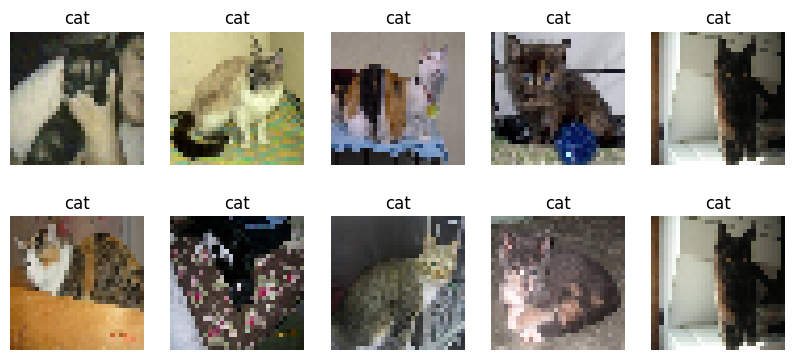

In [12]:
indices = np.random.randint(100,300,10)
show_images_batch(X_train[indices], names= y_train[indices])

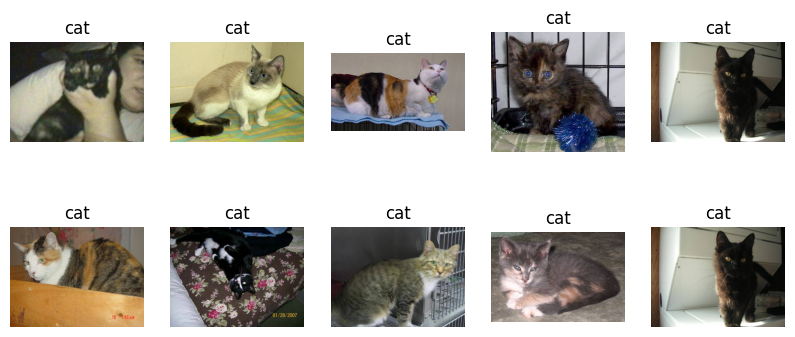

In [13]:
show_images_files([train_map[i] for i in indices], names= y_train[indices])

*Nos salen solo gatos porque están ordenados, veamos algunos simpáticos perritos*

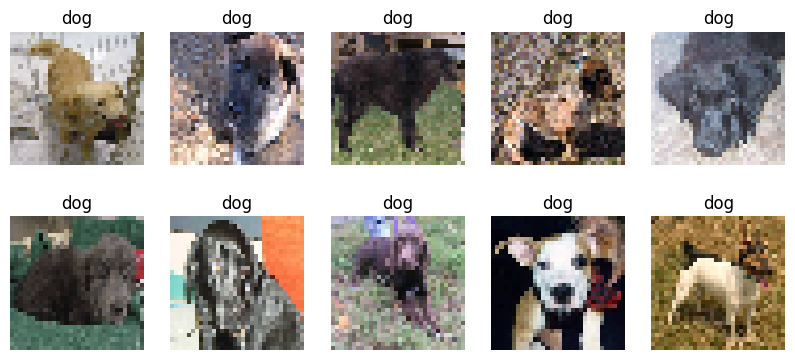

In [14]:
indices = np.random.randint(2000,2300,10)
show_images_batch(X_train[indices], names= y_train[indices])

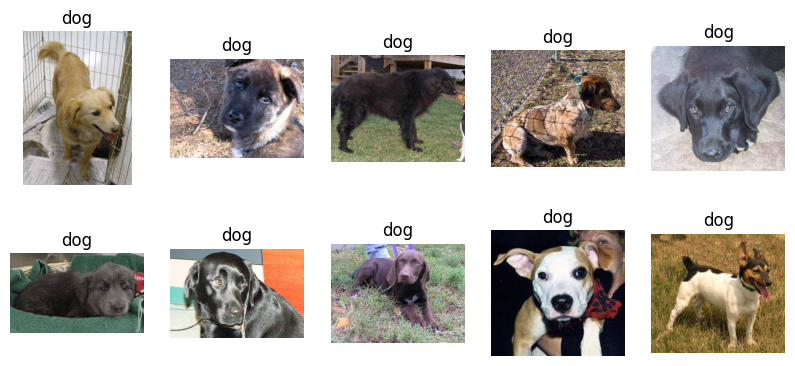

In [15]:
show_images_files([train_map[i] for i in indices], names= y_train[indices], train=2, indice=2)

#### MiniEDA

*Como en todo modelo de ML, y DL es un subconjunto, vamos a analizar el target*

In [16]:
pd.Series(y_train).value_counts(True)

,proportion
cat,0.5
dog,0.5


*Tenemos un dataset completamente equilibrado para un problema de clasificación binaria*

In [17]:
X_train.shape

(4000, 32, 32, 3)

#### Escalado

*Siempre es interesante hacer un escalado aunque sea el caso de imágenes con los canales ya "escalados" entre 0 y 255. Reducir el rango de 0/255 a -1/1 o 0/1, aprovecha mejoras las funciones de activación y evita problemas de saturación.*

In [18]:
X_train = X_train/255
X_test = X_test/255

#### Shuffle [Optativo]

*Como los datos están ordenados, es necesario darle cierta aleatoriedad, aunque internamente se van a procesar aleatoriamente al construir los batches, si de partida estan ordenado. Lo veremos más adelante*

*EXTRA: Construimos un randomforest como baseline*

In [19]:
def aplana_escala_gris(array_in, grises = True): # una función dentro de una función (scope es nonlocal)
    def convertir_a_escala_de_grises(imagen_color):
        coeficientes = np.array([0.2989, 0.5870, 0.1140]) # para pasar de color  agris, 2 colores distintos pueden dar mismo gris
        imagen_gris = np.dot(imagen_color[...,:3], coeficientes) # combinación lineal para los grises
        return imagen_gris

    if array_in.shape[-1] == 3 and grises: # si es en color y quiero pasar a grises
        array_in = np.array([convertir_a_escala_de_grises(imagen) for imagen in array_in])
    return array_in.reshape(array_in.shape[0],-1) # aplanado

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_train_rf = aplana_escala_gris(X_train)
len(X_train_rf[0]) # 32 x 32 píxeles estirados


1024

In [21]:
from sklearn.utils import shuffle
X_train_rf_shuffled, y_train_shuffled = shuffle(X_train_rf, y_train, random_state = 42)

In [22]:
y_train[0:10]

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat'], dtype='<U3')

In [23]:
y_train_shuffled[0:10]

array(['cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'cat'], dtype='<U3')

In [24]:
rf_clf = RandomForestClassifier()
np.mean(cross_val_score(rf_clf,X_train_rf_shuffled, y_train_shuffled, cv = 5, scoring = "accuracy"))

0.6115

*Un 61% de accuracy es lo mínimo que debemos exigir*

#### EXTRA-Tool: Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [25]:
np.savez(PATH_DATA + 'data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar

In [26]:
data = np.load(PATH_DATA + 'data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

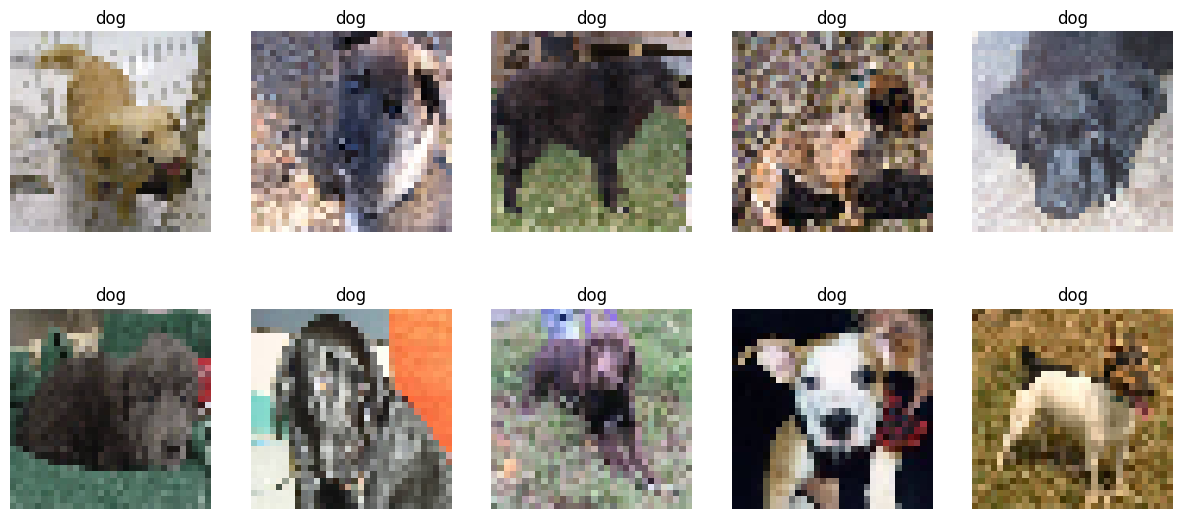

In [27]:
show_images_batch(X_train[indices],y_train[indices],size_scale=3)

### #2

*A la hora de crear un modelo DL, recuerda que necesitamos fijar una serie de hiperparámetros de partida, no es como cuando instanciamos nuestros modelos en Sklearn que ya vienen "preconfigurados". El orden en este caso suele ser:*

*1. Topología (I): Capas, conexión entre capas, vamos a hacer expansión-reducción de features, reducción-expansión, prismas, aplanamiento, dropout, etc*  
*2. Topología (II): Hiperparámetros por capa: unidades para las densas, kernel, strides, filtros, padding para convolucionales y pooling, drop-out rate para drop-out, etc*  
*3. Otros hiperparámetros: Tipo de optimizador (y sus hiperparámetros, en general usaremos los por defecto, salvo en ocasiones el learning rate), tamaño del batch (aunque en general será 32 y dependerá del tamaño del dataset de train), épocas de entrenamiento, % del conjunto de validación.*  
*4. Métrica y función de pérdida*  
*5. Uso de callbacks (en Keras): En general usaremos o EarlyStopping y/o ModelCheckpoint, pero [aquí](https://keras.io/api/callbacks/) tienes unas cuantas más de las estándar de Keras*  

*Vamos a crear una topología parecida a la de la figura*

#### Topología I-II:

*Vamos a construir una red como la de la figura:*



![image.png](attachment:abd8b990-2217-48b9-b545-29bd38576abe.png)

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

*Con los siguientes hiperparámetros:*  

***Primer juego Conv-Pooling:***
* *Conv -> kernel de 3x3, stride = (1,1), padding = "same", activation = "relu", numero de filtros = 64*  
* *Pooling -> max, kernel 2x2, stride = (2,2)) -> Vamos a reducir en 2x2, 4 el número de features*  
* *Features de salida: 16*16*64 = 16384

*Capa Dropout: 0.25 de ratio*

***Segundo juego con Conv-Pooling:*** *Aplicamos expansión, aumentando el número de filtros, pensamos en buscar más características de características*  
* *Conv -> kernel de 3x3, stride = (1,1), padding = "same", activation = "relu", numero de filtros = 128*  
* *Pooling -> max, kernel 2x2, stride = (2,2)) -> Vamos a reducir en 2x2, 4 el número de features*  
* Features de salida 8*8*128 = 8192
  
*Capa Dropout: 0.25 de ratio*  

*Capa aplanadora: Flatten() -> Nos deja cada instancia en un vector de 8192 features  
***Cabeza clasificacion:*** *1 densa oculta y la de salida. La oculta empezamos con una reducción de 8192 a 512, un factor de 16. Podríamos haberla dejado en 32x32 = 1024 features que es el número que meteríamos en un modelo tradicional*
* *Capa Oculta Densa: 128 unidades, activación "relu"*
* *Capa densa de salida: 1 unidad (es clasificador binario), activacuón "softmax"*


In [28]:
layers = [
    keras.layers.Input((32,32,3)),
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same"), # Padding "Valid" (sin padding), "Same" (ajusta para que entre todo), Integer -> el relleno que yo quiera.
    # me quedan 64 fotos transformadas de cada una, con tamaño 32x32
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 2x2 -> A dividir por 2 la resolución de cada dimensión de la capa anterior, 32x32 -> 16x16
    keras.layers.Dropout(rate = 0.25),

    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"), # de cada una transformada salen 128
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 16x16 -> 8x8
    keras.layers.Dropout(rate = 0.25),

    keras.layers.Flatten(), # 1 * 32 * 32 * 64 * 0.5 * 0.5 * 128 * 0.5 * 0.5 -> 524288 features nuevas por foto original de 32x32 y esto en los 3 planos de color
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate = 0.5),
    #keras.layers.Dense(2, activation='softmax') # -> loss = "sparse_categorical_crossentropy" (categorical_crossentropy es cuando y_train = [0,1] o y_train = [0,0,1,0,0]
    keras.layers.Dense(1, activation='sigmoid') # -> loss = "binary_crossentropy"
]
model = keras.Sequential(layers)

In [29]:
1+1

2

#### Otros hiperparámetros

*Veamos el tamaño de entrada de datos:*

In [30]:
X_train.shape

(4000, 32, 32, 3)

In [31]:
X_train.size

12288000

*Nos vale un Adam, podríamos probar un SGD*

In [32]:
optimizer = keras.optimizers.Adam()

In [33]:
metrics = ["accuracy"] # dataset equilibrado
loss = "binary_crossentropy" # Es un clasificador binario

*Tenemos 4000 instancias, no son tantas así que emplearemos un batch size de 32*

In [34]:
batch_size = 32
len(X_train)/batch_size

125.0

*Cada época tendrá 125 pasadas por el algoritmo de entrenamiento, también llamados steps. Incluso podríamos aumentar a 48-64 el batch_size*

*Escogemos un número alto de épocas y usamos un EarlyStopping con paciencia 10 para no tener que depender del número de épocas*

In [35]:
num_epochs = 100

In [36]:
earlyS = keras.callbacks.EarlyStopping(patience = 10)

*Compilamos y mostramos un resumen del modelo*

In [37]:
model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,270,977 (16.29 MB)

 Trainable params: 4,270,977 (16.29 MB)

 Non-trainable params: 0 (0.00 B)

### #3

*Hora de entrenar y mostrar ese entrenamiento, pero primero vamos a lanzar una sóla época para ver tiempos y antes convertir el target a numérico*

In [39]:
y_train[np.array([1,2,3560])] # las etiquetas son str

array(['cat', 'cat', 'dog'], dtype='<U3')

In [40]:
y_train_num = np.array([0 if y == "cat" else 1 for y in y_train]) # Tiene que ser un array de numpy o no lo admitirá el fit si queremos validation set

*Como vamos a tener que lanzar varios entrenamientos para poder simular un reseteo de pesos creamos una función que nos hace eso, nos devuelve el modelo preparado para un nuevo fit*

In [41]:
def prepare_model(resolucion = (32,32)):
    layers = [keras.layers.Input((32,32,3)),
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"),
    keras.layers.Dropout(rate = 0.25),

    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"),
    keras.layers.Dropout(rate = 0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(1, activation='sigmoid')
    ]
    model = keras.Sequential(layers)
    optimizer = keras.optimizers.Adam()
    metrics = ["accuracy"] # dataset equilibrado
    loss = "binary_crossentropy" # Es un clasificador binario
    model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)
    return model


In [42]:
model = prepare_model()
t_zero = time()
history = model.fit(X_train,
          y_train_num,
          epochs=1, # una época
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)
dur_epoca = time()-t_zero

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.5915 - loss: 0.6977 - val_accuracy: 0.0000e+00 - val_loss: 0.8834


In [43]:
print(dur_epoca)

21.81521487236023


*5-6 segundos podemos usar un número alto de épocas, pero eso sí ojo con los resultados por si son excesivamente positivos, tendríamos que estar preocupados*

In [44]:
model = prepare_model()
t_zero = time()
history = model.fit(X_train,
          y_train_num,
          epochs= num_epochs,
          batch_size= batch_size,
          callbacks = [earlyS], # early stop de 10 épocas
          validation_split=0.2)
dur_epoca = time()-t_zero

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.6339 - loss: 0.7385 - val_accuracy: 0.0000e+00 - val_loss: 0.7340
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.6361 - loss: 0.6488 - val_accuracy: 0.5138 - val_loss: 0.7009
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.6755 - loss: 0.5994 - val_accuracy: 0.3812 - val_loss: 0.8648
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.7061 - loss: 0.5693 - val_accuracy: 0.6925 - val_loss: 0.6096
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.7125 - loss: 0.5509 - val_accuracy: 0.6350 - val_loss: 0.6706
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.7370 - loss: 0.5427 - val_accuracy: 0.3575 - val_loss: 1.1163
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.7433 - loss: 0.5186 - val_accuracy: 0.5788 - val_loss: 0.7009
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.78

In [45]:
y_test_num = np.array([0 if y == "cat" else 1 for y in y_test]) # celda de arriba, early stop por defecto no se queda con los anteriores a parar
model.evaluate(X_test,y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7587 - loss: 0.5747


[0.5727477073669434, 0.7590000033378601]

In [46]:
model.metrics_names # el batch_size de evaluate es 32 por defecto

['loss', 'compile_metrics']

In [50]:
X_test.shape

(1000, 32, 32, 3)

In [51]:
1000/32 # por eso hay 32 steps

31.25

*Estos resultados pueden estar afectados por el orden de los datos de entrada recuerda que estaban completamente ordenados, primero gatos y perros. Vamos a shufflearlos*

In [ ]:
#from sklearn.utils import shuffle

In [48]:
X_s,y_s = shuffle(X_train,y_train_num) # barajado

In [49]:
model = prepare_model()
t_zero = time()
history_shuffle = model.fit(X_s,
          y_s,
          epochs= num_epochs,
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)
dur_epoca = time()-t_zero

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.5346 - loss: 0.7786 - val_accuracy: 0.6450 - val_loss: 0.6703
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.5949 - loss: 0.6659 - val_accuracy: 0.6350 - val_loss: 0.6446
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.6628 - loss: 0.6197 - val_accuracy: 0.6888 - val_loss: 0.6028
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.6868 - loss: 0.5869 - val_accuracy: 0.6988 - val_loss: 0.5753
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.7166 - loss: 0.5539 - val_accuracy: 0.6975 - val_loss: 0.5778
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.7535 - loss: 0.5121 - val_accuracy: 0.7325 - val_loss: 0.5562
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.7392 - loss: 0.5152 - val_accuracy: 0.7063 - val_loss: 0.5637
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.7695 -

In [52]:
y_test_num = np.array([0 if y == "cat" else 1 for y in y_test])
model.evaluate(X_test,y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7598 - loss: 0.6250


[0.6024805903434753, 0.7630000114440918]

*Pintemos la evolución de los dos entrenamientos*

In [53]:
df_evol = pd.DataFrame(history.history)
df_evol_shuffle = pd.DataFrame(history_shuffle.history)

<Axes: >

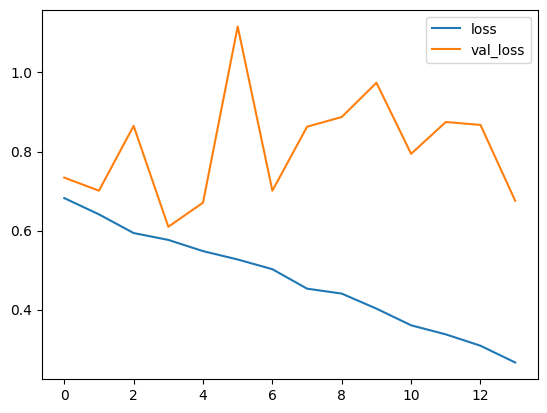

In [54]:
df_evol[["loss","val_loss"]].plot()

<Axes: >

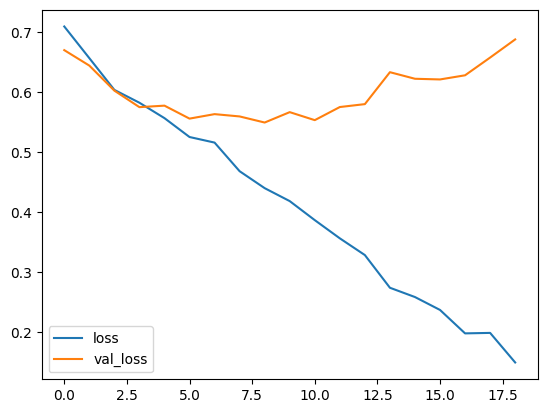

In [55]:
df_evol_shuffle[["loss","val_loss"]].plot()

*No siempre debemos parar en cuanto val y train se separan pero tampoco esperar mucho más. El no aleatorizar de primeras hace que el entrenamiento sin shuffling sea más oscilante, pero en este caso el impacto ha sido menor (hay un shuffle activado en el fit de los modelos keras)*

### #4

In [56]:
predictions = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [57]:
y_pred = ["dog" if prediction[0] > 0.5 else "cat" for prediction in model.predict(X_test)]
print(classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

         cat       0.77      0.74      0.76       500
         dog       0.75      0.78      0.77       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



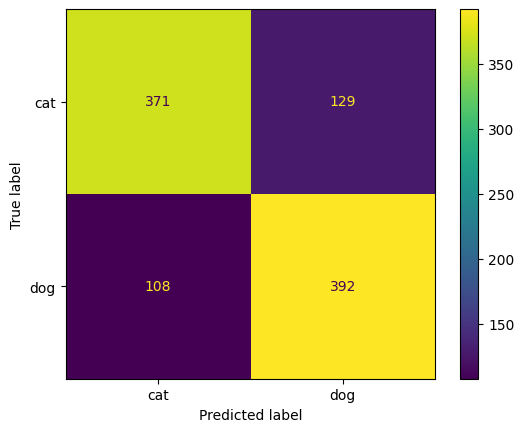

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### #5

*Aprovechemos que el test está también ordenado:*

Si es menor 0.5:  
Yo pensaré que es un gato, y pensaré con mayor intensidad o confianza cuanto menor sea la probabilidad -> 1 - probabilidad  
Si es mayor que 0.5:  
Pensaré que es un perro, y pensaré con mayor intensidad o confianza cuanto mayor sea la probabilidad -> probabilidad

In [59]:
confidencia = [ (1-prediction[0]) if prediction[0] <= 0.5 else prediction[0] for prediction in model.predict(X_test)]
df_pred = pd.DataFrame({"ficheros": test_map,"True": [file.split(".")[0] for file in test_map],"Prediction": y_pred, "Confidencia": confidencia})
df_pred

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


,ficheros,True,Prediction,Confidencia
0,dog.9631.jpg,dog,cat,0.610363
1,dog.8469.jpg,dog,dog,0.992163
2,dog.8707.jpg,dog,cat,0.732056
3,dog.8871.jpg,dog,cat,0.887943
4,dog.9408.jpg,dog,dog,0.999098
...,...,...,...,...
995,cat.11739.jpg,cat,dog,0.982959
996,dog.8695.jpg,dog,dog,0.953846
997,dog.8495.jpg,dog,dog,0.914625
998,dog.8893.jpg,dog,dog,0.922437


In [60]:
errores = df_pred["True"] != df_pred["Prediction"]
son_gatos = df_pred["True"] == "cat"
son_perros = df_pred["True"] == "dog"
gatos_dificiles = df_pred[son_gatos & errores]["Confidencia"].nlargest(int(len(df_pred[son_gatos & errores])*0.1)).index.to_list()
perros_dificiles = df_pred[son_perros & errores]["Confidencia"].nlargest(int(len(df_pred[son_perros & errores])*0.1)).index.to_list()


In [61]:
df_pred.loc[gatos_dificiles]

,ficheros,True,Prediction,Confidencia
249,cat.11793.jpg,cat,dog,0.999998
419,cat.11867.jpg,cat,dog,0.999623
444,cat.11462.jpg,cat,dog,0.998188
83,cat.10740.jpg,cat,dog,0.996323
535,cat.11515.jpg,cat,dog,0.993291
29,cat.11899.jpg,cat,dog,0.992701
16,cat.10728.jpg,cat,dog,0.992322
55,cat.11787.jpg,cat,dog,0.989495
995,cat.11739.jpg,cat,dog,0.982959
215,cat.10716.jpg,cat,dog,0.981423


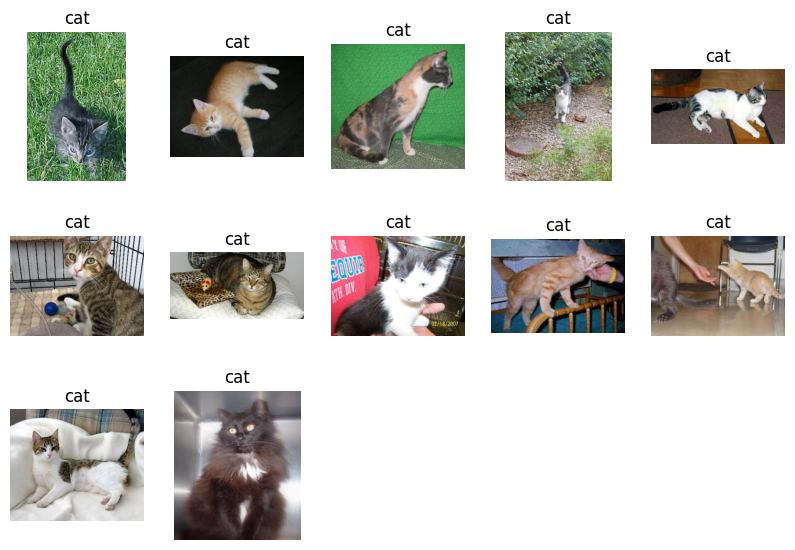

In [62]:
show_images_files(df_pred.loc[gatos_dificiles]["ficheros"], df_pred.loc[gatos_dificiles]["True"].values, train = False)

In [63]:
df_pred.loc[perros_dificiles]

,ficheros,True,Prediction,Confidencia
63,dog.9509.jpg,dog,cat,0.999993
129,dog.8117.jpg,dog,cat,0.999742
808,dog.9876.jpg,dog,cat,0.999661
653,dog.9639.jpg,dog,cat,0.999117
800,dog.8485.jpg,dog,cat,0.998922
913,dog.9607.jpg,dog,cat,0.997206
666,dog.9530.jpg,dog,cat,0.993171
253,dog.8451.jpg,dog,cat,0.988933
829,dog.8882.jpg,dog,cat,0.988277
551,dog.9346.jpg,dog,cat,0.986426


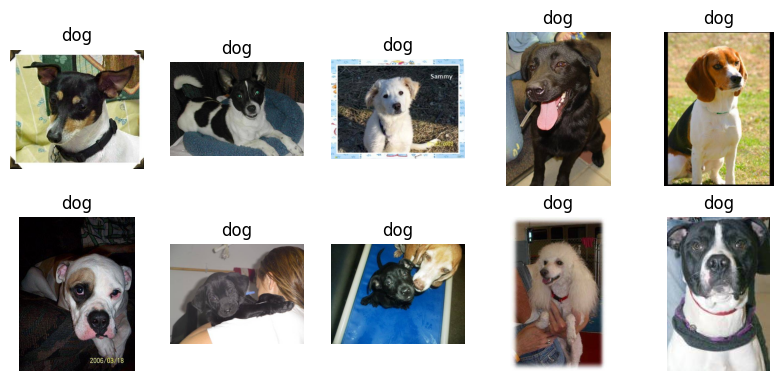

In [64]:
show_images_files(df_pred.loc[perros_dificiles]["ficheros"], df_pred.loc[perros_dificiles]["True"].values, train = False)

*La discusión es si la resolución afecta, que sí y tendríamos que hacerlo suponiendo esa resolución. Por otro lado, el que sean imágenes que a un humano no le costarían pero sí a un modelo las hace más idóneas para el trabajo porque fallarlas es signo inequívoco de que es un modelo*

### EXTRA

*Para terminar vamos a ver una de las técnicas que se pueden emplear para tener más informacio´n en un clasificador de imágenes (y que podría servir hasta cierto punto como técnica de generación sintética o oversampling para equilibrar datasets)*

*Vamos a ver cómo usar los augmentadores de datasets de keras para imágenes*

#### Image data generator

*Primero vamos a coger el train y vamos a construir un dataset con la estructura filename-category que nos servirá después para ver otra capacidad de keras*

In [65]:
directorios  = [f"{PATH_DATA}github_train_{i}" for i in range(0,4)]
ficheros = []
clases = []
for directorio in directorios:
    ficheros += [directorio + "/" + fichero for fichero in os.listdir(directorio)]
    clases += [fichero.split(".")[0] for fichero in os.listdir(directorio)]
train_augmented = pd.DataFrame({"filename": ficheros,"category": clases})
train_augmented.head(10)



,filename,category
0,./data/data/github_train_0/cat.10058.jpg,cat
1,./data/data/github_train_0/cat.1346.jpg,cat
2,./data/data/github_train_0/cat.18.jpg,cat
3,./data/data/github_train_0/cat.2294.jpg,cat
4,./data/data/github_train_0/cat.3667.jpg,cat
5,./data/data/github_train_0/cat.2211.jpg,cat
6,./data/data/github_train_0/cat.583.jpg,cat
7,./data/data/github_train_0/cat.3779.jpg,cat
8,./data/data/github_train_0/cat.10067.jpg,cat
9,./data/data/github_train_0/cat.2047.jpg,cat


*El objeto ImageDataGenerator va a servirnos para generar una imagen modificada de una imagen original, mediante rotacinoes, reescalados, desplazamientos, zooms, flips, etc*

In [66]:
'''
NO genera X imagenes sinteticas. Simplemente en cada epoch, en vez de coger el
dataset tal cual lo tiene, coge una de esas imágenes sintéticas, algo diferentes,
Asi eumentan sus perspectivas
Las imagenes las va generando segun entrena

'''

example_df = train_augmented.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15, # Angulo de rotación
    rescale=1./255, # Escalado, ya nos escala las imágenes
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)


*Dos formas de utilizarlo, desde la lectura de ficheros y desde los datos*

In [67]:
example_df

,filename,category
0,./data/data/github_train_1/cat.324.jpg,cat


In [68]:

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    x_col='filename',
    y_col='category',
    target_size=(32, 32),
)

Found 1 validated image filenames belonging to 1 classes.


*Generamos ahora 15 imágenes sintéticas, se le aplican los cambios aletoriamente*

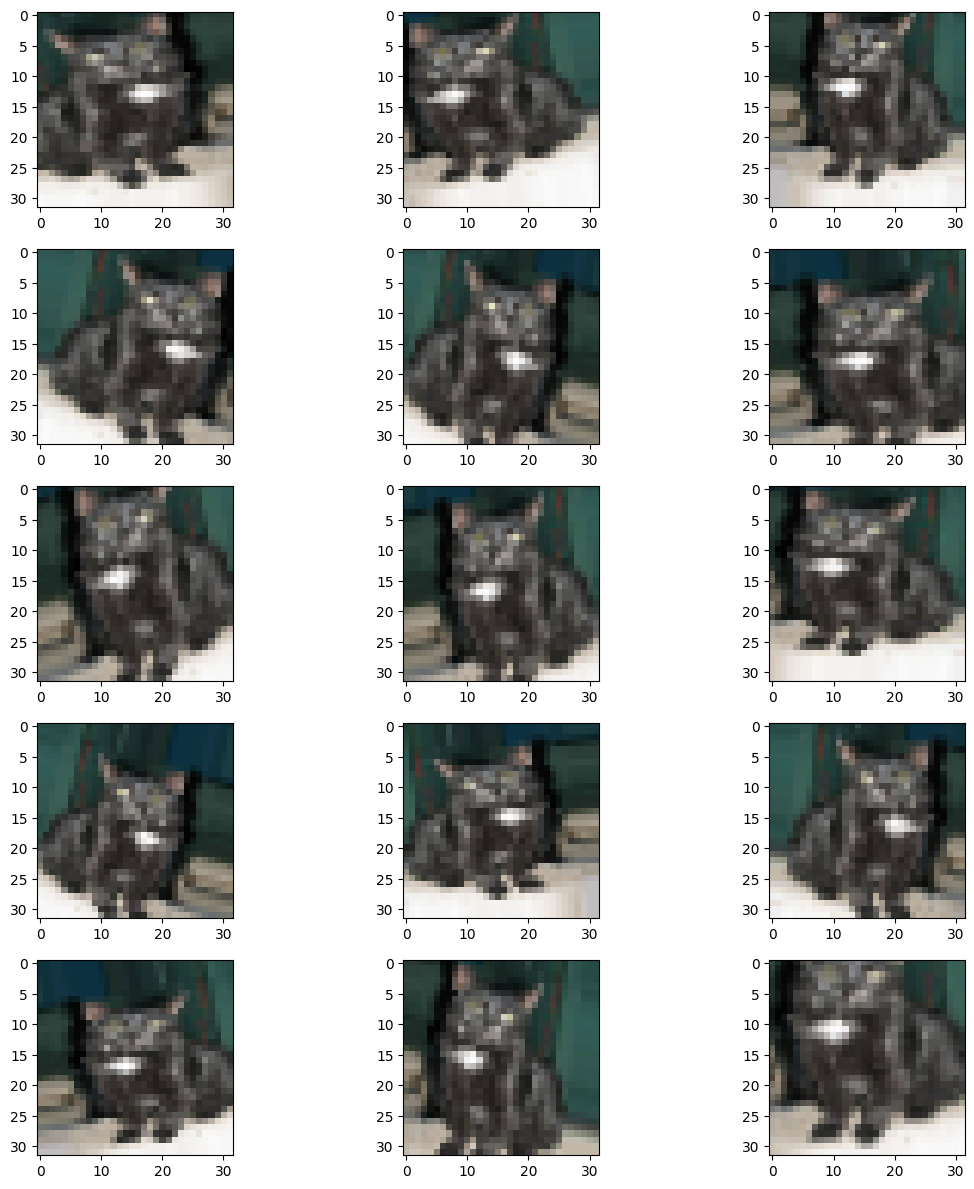

In [69]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show() # genera imágenes aumentadas a partir de una en este caso

In [70]:

example_generator = train_datagen.flow(
    X_train[0:3]*255,
    y_train[0:3]
)

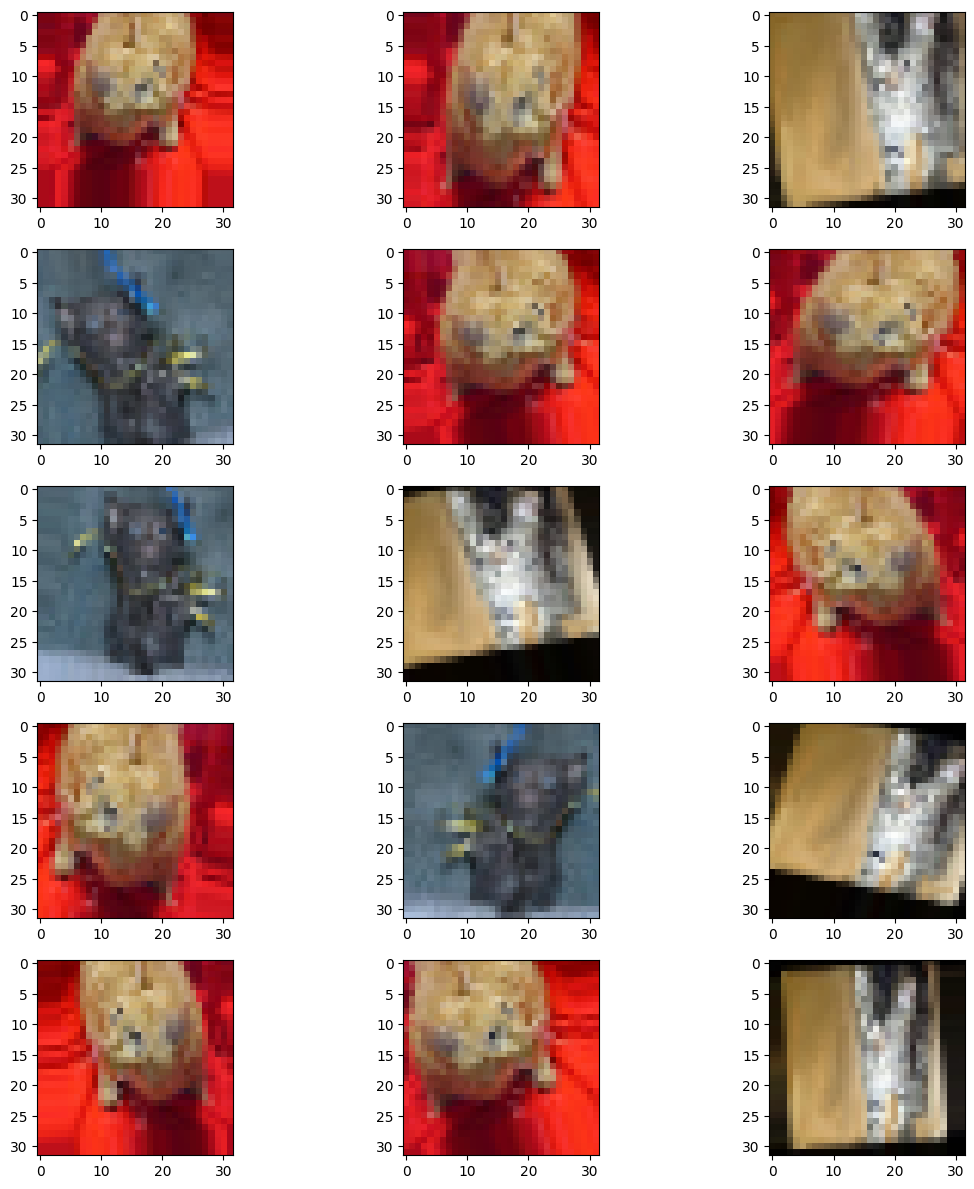

In [71]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show() # genera imágenes aumentadas a partir de 3 en este caso

#### Aplicado a un modelo y un entrenamiento

*Tenemos que generar el dataset de validación aparte, porque ese no va a llevar aumentación*

In [72]:
train_df, validate_df = train_test_split(train_augmented, # train_augmented es el dataframe con una foto distinta por fila
                                         test_size=0.20,
                                         random_state=42)

In [73]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df

,filename,category
0,./data/github_train_3/dog.9982.jpg,dog
1,./data/github_train_0/cat.2440.jpg,cat
2,./data/github_train_2/dog.9981.jpg,dog
3,./data/github_train_1/cat.1657.jpg,cat
4,./data/github_train_0/cat.2753.jpg,cat
...,...,...
3195,./data/github_train_1/cat.1303.jpg,cat
3196,./data/github_train_1/cat.1882.jpg,cat
3197,./data/github_train_0/cat.487.jpg,cat
3198,./data/github_train_3/dog.11270.jpg,dog


In [74]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0] # validación no cruzada

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

Shape train 3200
Shape validation 800


,filename,category
0,./data/data/github_train_0/cat.3221.jpg,cat
1,./data/data/github_train_3/dog.10842.jpg,dog
2,./data/data/github_train_0/cat.3460.jpg,cat
3,./data/data/github_train_3/dog.12060.jpg,dog
4,./data/data/github_train_2/dog.12031.jpg,dog


# Training Generator

In [75]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(32, 32),
    class_mode='binary', # Porque es binaria, si fuera multiclase y en un sólo valor -> "sparse" (otras configuraciones, ver la documentación)
    batch_size= batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


### Validation Generator

In [76]:
validation_datagen = ImageDataGenerator(rescale=1./255) # Solo vamos a reescalar
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col='filename',
    y_col='category',
    target_size=(32, 32),
    class_mode='binary',
    batch_size= batch_size
)

Found 800 validated image filenames belonging to 2 classes.


# Fit Model

In [77]:
model = keras.Sequential(layers)

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
history = model.fit(
    train_generator,
    epochs= num_epochs,
    validation_data=validation_generator,
    callbacks= earlyS
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.5149 - loss: 0.7146 - val_accuracy: 0.5738 - val_loss: 0.6700
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - accuracy: 0.5994 - loss: 0.6745 - val_accuracy: 0.6538 - val_loss: 0.6316
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.6277 - loss: 0.6370 - val_accuracy: 0.6775 - val_loss: 0.6267
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.6501 - loss: 0.6286 - val_accuracy: 0.6612 - val_loss: 0.5884
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.6796 - loss: 0.6059 - val_accuracy: 0.6300 - val_loss: 0.6303
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.6788 - loss: 0.6058 - val_accuracy: 0.6150 - val_loss: 0.6409
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.6783 - loss: 0.5940 - val_accuracy: 0.6812 - val_loss: 0.5778
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.7029 - loss: 0.566

In [79]:
results = model.evaluate(X_test, y_test_num)
print("test loss, test acc:", results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7833 - loss: 0.4786
test loss, test acc: [0.4762604236602783, 0.7860000133514404]


In [84]:
1+1

2

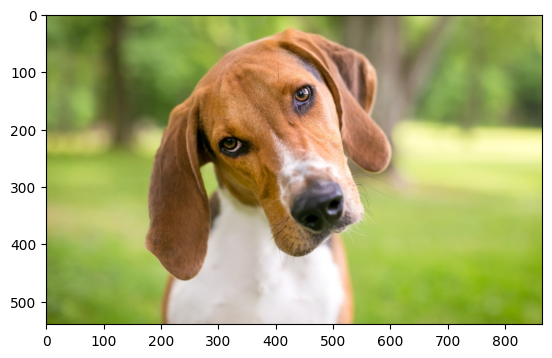

In [96]:
image = imread('./perro_test.jpg')
plt.imshow(image);

In [97]:
image = np.array([cv2.resize(image, (32, 32))/255])

In [98]:
image.shape

(1, 32, 32, 3)

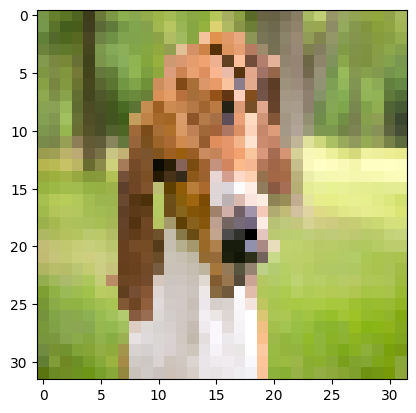

In [101]:
plt.imshow(image[0])

In [102]:
image.shape

(1, 32, 32, 3)

In [103]:
predictions = model.predict(image).round(3)
print("predictions shape:", predictions.shape)
predictions # ¡perro!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
predictions shape: (1, 1)


array([[0.989]], dtype=float32)